# Pendulum with Vibrating Base

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    LeafSystem,
    LogVectorOutput,
    MatrixGain,
    MeshcatVisualizer,
    Multiplexer,
    Parser,
    Simulator,
    StartMeshcat,
    plot_system_graphviz,
)

from underactuated import ConfigureParser, ManipulatorDynamics

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://ba2c453b-ae26-4598-b478-09b782cd6342.deepnoteproject.com/7000/


## Problem Description
In this problem you will write the controller to make the pendulum with vibrating base spin at constant velocity.
At the end of the notebook, you will be able to check your work in a simulation environment we set up for you.

**These are the main steps of the exercise:**
1. Construct the physical model of the vibrating pendulum. This is done automatically by "parsing" a `.urdf` (Unified Robot Description Format) file.
2. Implement the controller you derived in the written part of this exercise. _This is the only piece of code you will need to write._
3. Wire up the closed-loop block diagram: connect the controller output with the system input, the system output with the visualizer etc.
4. Set up and run a simulation.

In [3]:
# parameters of the harmonic motion of the base
# defined globally in the notebook
h = 1.0
omega = np.pi

## Parse the `.urdf`
The first block of our diagram is the vibrating pendulum.
No need to write its equations of motion by hand: all the parameters of the system are described in its `.urdf` file.
Drake can directly parse this file, and construct a `MultibodyPlant` (i.e. the vibrating-pendulum block in our diagram).
The `.urdf` file contains all the physical data of the system, the visualization parameters (shapes and colors of the bodies), etc.
Its html-like syntax is very easy to understand, give it a try!

Our robot has two bodies:
1. The base. This moves on a 1D rail and oscillates according to the harmonic law $h \sin (\omega t)$.
2. The pendulum. It is connected to the base through a pin. This is the body you will need to control.

**Attention!** Since the robot has two bodies, it also has two configuration variables.
When writing the controller, we will take care of the first (position of the base) and ensure that it oscillates as required.
Then the problem will be reduced to the control of the pendulum only.

In [4]:
# think of the builder as the construction site of our block diagram
builder = DiagramBuilder()

# instantiate the vibrating pendulum and the scene graph
# the scene graph is a container for the geometries of all the physical systems in our diagram
vibrating_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
    builder,
    time_step=0.0,  # discrete update period , set to zero since system is continuous
)

# parse the urdf and populate the vibrating pendulum
parser = Parser(vibrating_pendulum)
ConfigureParser(parser)
parser.AddModelsFromUrl("package://underactuated/models/vibrating_pendulum.urdf")
vibrating_pendulum.Finalize()

# we set names for the systems to make our diagram more readable
vibrating_pendulum.set_name("Vibrating Pendulum")
scene_graph.set_name("Scene Graph")

## Write the Controller
In this section we define two controllers:
1. An inner controller that makes the base oscillate with the harmonic motion. We wrote this for you.
2. The outer controller to make the pendulum spin at constant velocity. You will write part of this.

The final diagram will have the following structure:

![figure](https://raw.githubusercontent.com/RussTedrake/underactuated/master/book/figures/exercises/vibrating_pendulum.jpg)

In [5]:
# this controller enforces the harmonic motion to the base


class InnerController(LeafSystem):
    def __init__(self, vibrating_pendulum):
        # 5 inputs: state of base + pendulum, pendulum torque
        # 2 outputs: force on base + torque on pendulum
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("u", 5)
        self.DeclareVectorOutputPort("y", 2, self.DoCalcVectorOutput)
        self.vibrating_pendulum = vibrating_pendulum

    def DoCalcVectorOutput(
        self,
        context,
        output,  # force on base + torque on pendulum
    ):
        # unpack plant state from input port
        controller_input = self.get_input_port(0).Eval(context)
        q = controller_input[:2]  # base position + pendulum angle
        q_dot = controller_input[2:4]  # time derivative of q

        # extract manipulator equations: M*a + Cv = tauG + B*u + tauExt
        # (for this system B is the identity and the external forces tauExt are zero
        # hence, for simplicity, we will just drop them from the code)
        M, Cv, tauG, B, tauExt = ManipulatorDynamics(self.vibrating_pendulum, q, q_dot)
        Minv = np.linalg.inv(M)
        tau = tauG - Cv

        # desired acceleration of the base
        # note that this depends on time
        t = context.get_time()
        a_base = -(omega**2) * h * np.sin(omega * t)

        # cancel out the dynamics of the pendulum
        # and enforce harmonic motion to the base
        # (to fully explain these lines we would need a small math derivation,
        # since this is not the goal of the exercise we skip it,
        # if you want, you can try your own, it is not hard)
        torque = controller_input[-1]
        force = -tau[0]  # cancel gravity, centrifugal, and Coriolis
        force += (
            -(tau[1] + torque) * Minv[0, 1] / Minv[0, 0]
        )  # cancel pendulum effects on the base
        force += a_base / Minv[0, 0]  # enforce desired acceleration

        # control signal
        output.SetFromVector([force, torque])

In [6]:
# this is the controller that makes the pendulum spin at constant velocity
# you will write the control law in it in the next cell
# by defining the function called "pendulum_torque"


class OuterController(LeafSystem):
    def __init__(self, vibrating_pendulum, pendulum_torque):
        # 2 inputs: pendulum state
        # 1 output: torque on pendulum
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("u", 2)
        self.DeclareVectorOutputPort("y", 1, self.DoCalcVectorOutput)
        self.vibrating_pendulum = vibrating_pendulum
        self.pendulum_torque = pendulum_torque

    def DoCalcVectorOutput(
        self,
        context,
        output,  # torque on pendulum
    ):
        # unpack state from input port
        controller_input = self.get_input_port(0).Eval(context)
        theta, theta_dot = controller_input

        # get pendulum parameters
        # absolute values to make these parameters positive
        pendulum = self.vibrating_pendulum.GetBodyByName("pendulum")
        m = pendulum.default_mass()
        g = np.abs(self.vibrating_pendulum.gravity_field().gravity_vector()[2])
        l = np.abs(pendulum.default_com()[2])

        # controller
        t = context.get_time()
        output.SetFromVector([self.pendulum_torque(m, g, l, theta, theta_dot, t)])

In the following cell, modify the function `pendulum_torque` to implement the control law you derived in the point (b) of the exercise.
The function must return the torque to be applied to the pendulum (`int` or `float`).
Currently, it just returns zero torque, and the pendulum oscillates freely.

The parameters of this function are:
- `m`: mass of the bob of the pendulum,
- `g`: gravity acceleration ($>0$),
- `l`: length of the pendulum rod,
- `theta`: angle of the pendulum,
- `theta_dot`: angular velocity of the pendulum,
- `t`: time.

**Very important:**
To complete this assignment, you only need to work in the following cell.

In [7]:
def pendulum_torque(m, g, l, theta, theta_dot, t):
    torque = -m * l * g * (theta_dot - 1);
    torque += m * l * g * np.sin(theta);
    torque -= m * l * omega * omega * h * np.sin(omega*t) * np.cos(theta);
    return torque

## Wire up the Block Diagram
Now it is time to construct the block diagram: connect the controllers to the system, the sensors to the controllers, etc.
We aim to construct the diagram shown above, with the addition of a visualizer, which will be connected with the system state.

**Troubleshooting:**
Note that we already initialized the `builder` of the block diagram when parsing the `.urdf` file.
Hence, by running the following cell multiple times, you would actually try to wire the blocks in the diagram more than once.
This is not acceptable, and Drake will raise the error `RuntimeError: Input port is already wired.`
If you wish to modify the next cell and rerun the program to see the effects of your modification, you must rerun the cell where the `builder` is initialized first (i.e. the cell with the line `builder = DiagramBuilder()`).

In [8]:
# instantiate controllers
inner_controller = builder.AddNamedSystem(
    "Inner Controller", InnerController(vibrating_pendulum)
)
outer_controller = builder.AddNamedSystem(
    "Outer Controller", OuterController(vibrating_pendulum, pendulum_torque)
)

# instantiate visualizer
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
visualizer.set_name("Visualizer")
meshcat.Set2dRenderMode(xmin=-2.5, xmax=2.5, ymin=-1.5, ymax=2.5)

# logger that records the state trajectory during simulation
logger = LogVectorOutput(vibrating_pendulum.get_state_output_port(), builder)
logger.set_name("Logger")

# mux block to squeeze the (base + pendulum) state and
# the outer control signal in a single cable
mux = builder.AddNamedSystem("Mux", Multiplexer([4, 1]))

# selector that extracts the pendulum state from the state of the base and the pendulum
selector = builder.AddNamedSystem(
    "Pendulum-State Selector",
    MatrixGain(
        np.array(
            [
                [0, 1, 0, 0],  # selects the angle of the pendulum
                [0, 0, 0, 1],  # selects the angular velocity of the pendulum
            ]
        )
    ),
)

# (base + pendulum) state, outer control -> mux
builder.Connect(vibrating_pendulum.get_state_output_port(), mux.get_input_port(0))
builder.Connect(outer_controller.get_output_port(0), mux.get_input_port(1))

# mux -> inner controller
builder.Connect(mux.get_output_port(0), inner_controller.get_input_port(0))

# (base + pendulum) state -> selector
builder.Connect(vibrating_pendulum.get_state_output_port(), selector.get_input_port(0))

# selector -> outer controller
builder.Connect(selector.get_output_port(0), outer_controller.get_input_port(0))

# inner controller -> system input
builder.Connect(
    inner_controller.get_output_port(0),
    vibrating_pendulum.get_actuation_input_port(),
)

# finalize block diagram
diagram = builder.Build()
diagram.set_name("Block Diagram for the Control of the Vibrating Pendulum")

When connecting all the blocks by hand, it is possible to do some mistakes.
To double check your work, you can use the function `plot_system_graphviz`, which plots the overall block diagram you built.
You can compare the automatically-generated block diagram with the one above

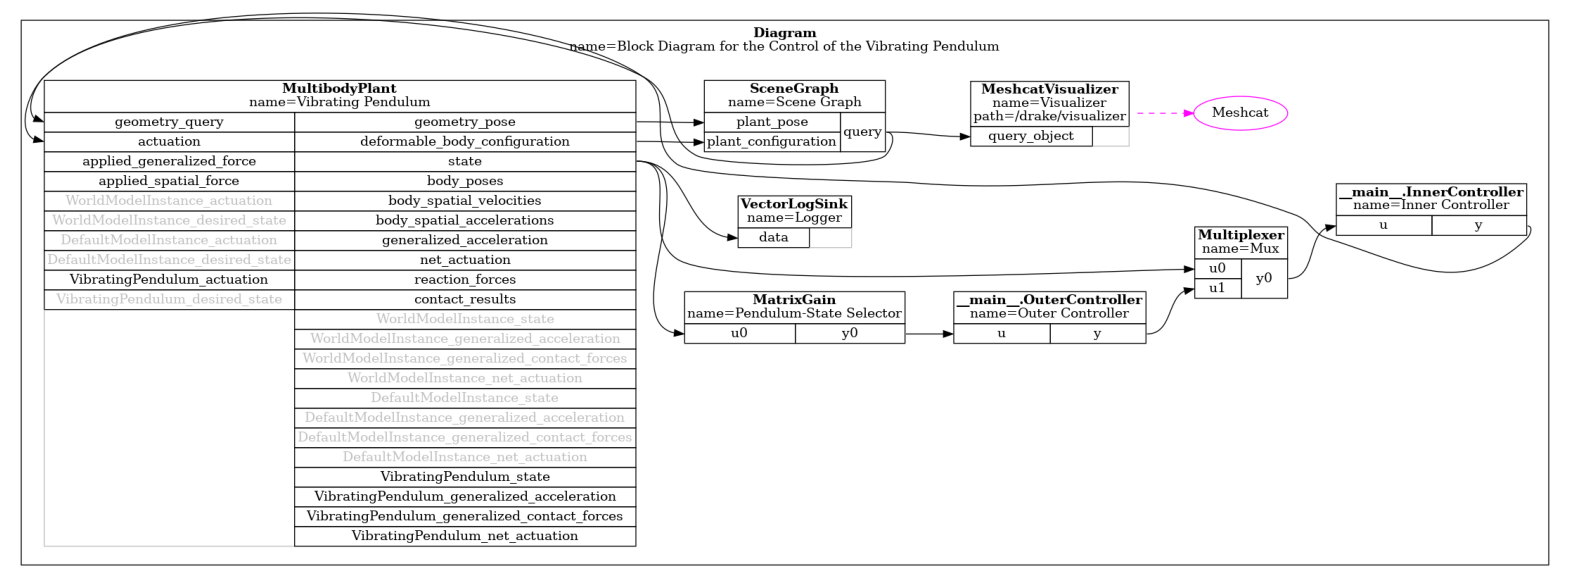

In [9]:
# give names to the blocks (just to make the plot nicer)

# plot current diagram
plt.figure(figsize=(20, 10))
plot_system_graphviz(diagram)

## Closed-Loop Simulation
Now we can finally simulate the system in closed loop with the controllers we wrote.
In the meanwhile, we will also set up a "video recording" with which we will be able to playback the simulation.
System trajectories will be stored in the `logger` and plotted in the last cell.

In [10]:
# initial state of the pendulum
theta = 0.0
theta_dot = 0.0

# simulation time
sim_time = 10

Make sure you have MeshCat visualizer window open in your browser (the URL is printed from the `StartMeshcat` cell near the top).  Then run the simulation:

In [11]:
# start recording the video for the animation of the simulation
visualizer.StartRecording()

# set up a simulator
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

# set the initial conditions
# do not change the initial conditions of the base
# since they must agree with the harmonic motion h*sin(omega*t)
context = simulator.get_mutable_context()
context.SetTime(0.0)  # reset current time
context.SetContinuousState(
    (
        0.0,  # initial position of the base, DO NOT CHANGE!
        theta,  # initial angle of the pendulum
        h * omega,  # initial velocity of the base, DO NOT CHANGE!
        theta_dot,  # initial angular velocity of the pendulum
    )
)

# simulate from zero to sim_time
simulator.Initialize()
simulator.AdvanceTo(sim_time)

# stop recording and send the animation to meshcat
visualizer.StopRecording()
visualizer.PublishRecording()

We conclude by plotting the position of the base and the angular velocity of the pendulum as functions of time.
If we did our job correctly,
- the first should coincide with the desired position $h \sin (\omega t)$,
- the second should coincide with the response of the first-order system $\ddot \theta = f(\dot \theta)$ you came up with in point (a) of the exercise.

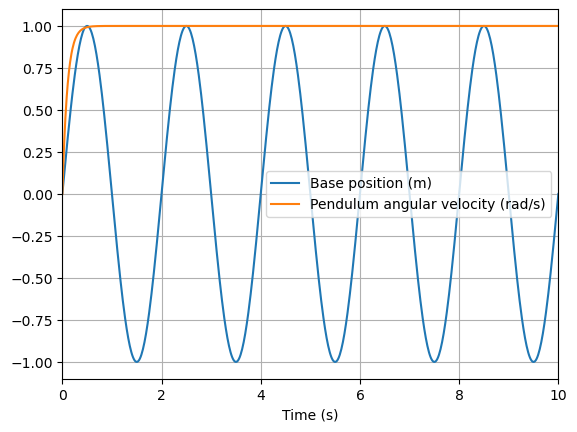

In [12]:
# base position as a function of time
log = logger.FindLog(context)
plt.plot(log.sample_times(), log.data()[0, :], label="Base position (m)")

# pendulum angular velocity as a function of time
plt.plot(
    log.sample_times(),
    log.data()[-1, :],
    label="Pendulum angular velocity (rad/s)",
)

# misc plot settings
plt.xlabel("Time (s)")
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()

## How Will this Notebook Be Graded?
If you are enrolled in the class, this notebook will be graded using [Gradescope](https://www.gradescope.com).
We will send you the details of how to access the course page in Gradescope by email.

We will replicate your work by running your notebook and checking the relevant functions (pendulum_torque) for correct outputs.
We will also test your work by looking at the response of the angular velocity $\dot \theta(t)$ from the plot above.
You will get full score if *all* the following tests succeed:
- The response $\dot \theta(t)$ is a nondecreasing function (a first order system, such as $\ddot \theta = f(\dot \theta)$, cannot oscillate).
- The terminal velocity $\dot \theta (t=10\text{ s})$ is less than $1.001 \text{ rad/s}$.
- The terminal velocity $\dot \theta (t=10\text{ s})$ is greater than $0.99 \text{ rad/s}$.

While the first two conditions should always hold (you did things properly), to fulfill the third you might want to increase your controller gains!

## Autograding
You can check your work by running the following cell:

In [13]:
from underactuated.exercises.grader import Grader
from underactuated.exercises.pend.test_vibrating_pendulum import TestVibratingPendulum

Grader.grade_output([TestVibratingPendulum], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 8/8.

Score for Test pendulum controller is 8/8.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba2c453b-ae26-4598-b478-09b782cd6342' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>